In [178]:
import torch
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm 



In [52]:
transform = transforms.Compose([transforms.ToTensor()])


In [183]:
# Loading the images with the new annotations we did
train_dataset = CocoDetection(
    root="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/train",
    annFile="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/train/_annotations.coco.json",
    transform=transform
)

val_dataset = CocoDetection(
    root="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/valid",
    annFile="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/valid/_annotations.coco.json",
    transform=transform
)

test_dataset = CocoDetection(
    root="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/test",
    annFile="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/test/_annotations.coco.json",
    transform=transform
)


# This will give us the image as a Tensor [3,H,W], each image with the three channels with the hight and width
# Our target wich is the bounding boxes with the class (Car)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [54]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [184]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn, 
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=2, 
    shuffle=False, 
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,     
    shuffle=False,    
    collate_fn=collate_fn
)



In [56]:
# The images are the list of images with the 3 channels while the target is the list of annotations for each image
images, targets = next(iter(train_loader))

Plotting a sample from the images to check how the bounding boxs looks like, used Matplotlib patches so it can accept [x, y, width, height] which matches the COCO format

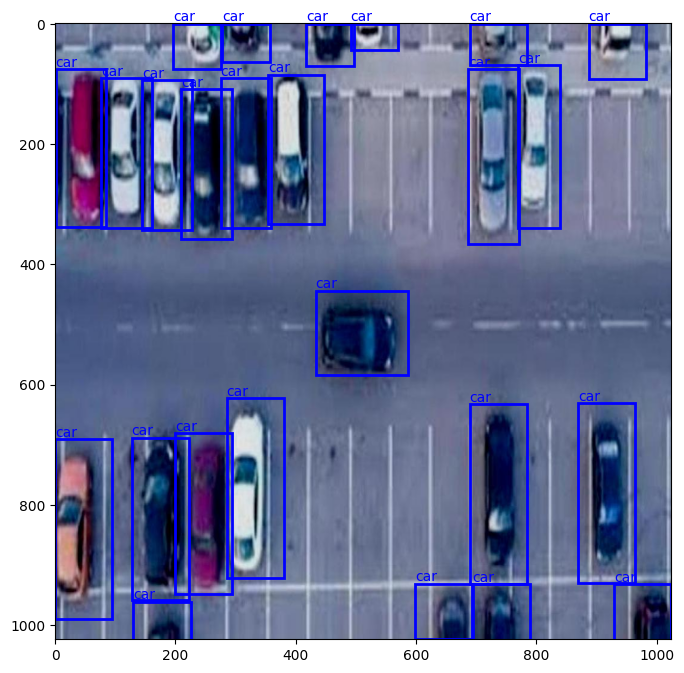

In [57]:
# Get one sample
img, anns = train_dataset[0]

# Convert tensor to numpy image
img = img.permute(1, 2, 0).numpy()
img = (img * 255).astype("uint8")

# Plot
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)

# Loop over all annotations for this image
for ann in anns:
    x, y, w, h = ann['bbox']  # COCO format
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y-5, "car", color='blue', fontsize=10)

plt.show()


In [60]:
model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")


In [65]:
print(model.head.classification_head)


SSDLiteClassificationHead(
  (module_list): ModuleList(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=672, bias=False)
        (1): BatchNorm2d(672, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(672, 546, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
        (1): BatchNorm2d(480, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(480, 546, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
        (1): BatchNorm2d(512, eps=0.001, momentum=0.03, a

In [66]:
# Find a Conv2d inside the module_list
sample_layer = model.head.classification_head.module_list[0][1]  # <- second element is Conv2d

in_channels = sample_layer.in_channels
num_anchors = sample_layer.out_channels

print("in_channels:", in_channels)
print("num_anchors:", num_anchors)


in_channels: 672
num_anchors: 546


In [70]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
import torch.nn as nn

# 1. Load pretrained MobileNet SSD
model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")

# 2. Dig into the old head to get settings
old_head = model.head.classification_head

# each prediction layer is built from module_list
in_channels = []
num_anchors = []
for m in old_head.module_list:
    # m is a Sequential -> last layer is Conv2d that outputs anchors * classes
    conv = m[1]   # Conv2d
    in_channels.append(conv.in_channels)
    num_anchors.append(conv.out_channels // 91)  # since pretrained COCO has 91 classes


In [71]:
params = [p for p in model.parameters() if p.requires_grad]

# Define optimizer (works well for SSD models)
optimizer = torch.optim.SGD(
    params, 
    lr=0.005,           # learning rate
    momentum=0.9,       # helps stabilize training
    weight_decay=0.0005 # regularization
)

In [89]:
num_epochs = 50 

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, targets in loop:
        images = [img for img in images]  # keep on CPU

        formatted_targets = []
        for anns in targets:
            boxes, labels = [], []
            for ann in anns:
                x, y, w, h = ann['bbox']
                x2, y2 = x + w, y + h
                boxes.append([x, y, x2, y2])
                labels.append(1)  # only "car"

            if len(boxes) > 0:
                formatted_targets.append({
                    "boxes": torch.tensor(boxes, dtype=torch.float32),
                    "labels": torch.tensor(labels, dtype=torch.int64)
                })
            else:
                # empty case handled safely
                formatted_targets.append({
                    "boxes": torch.zeros((0, 4), dtype=torch.float32),
                    "labels": torch.zeros((0,), dtype=torch.int64)
                })

        # Forward pass
        loss_dict = model(images, formatted_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        loop.set_postfix(loss=losses.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {epoch_loss:.4f}")


Epoch 1/50: 100%|██████████| 109/109 [02:12<00:00,  1.22s/batch, loss=3.3] 


Epoch 1/50, Total Loss: 272.4489


Epoch 2/50: 100%|██████████| 109/109 [02:11<00:00,  1.21s/batch, loss=2.43]


Epoch 2/50, Total Loss: 264.8199


Epoch 3/50: 100%|██████████| 109/109 [02:06<00:00,  1.16s/batch, loss=2.21]


Epoch 3/50, Total Loss: 259.6363


Epoch 4/50: 100%|██████████| 109/109 [02:06<00:00,  1.16s/batch, loss=2.59]


Epoch 4/50, Total Loss: 264.6685


Epoch 5/50: 100%|██████████| 109/109 [02:06<00:00,  1.16s/batch, loss=2.03]


Epoch 5/50, Total Loss: 249.5505


Epoch 6/50: 100%|██████████| 109/109 [02:02<00:00,  1.13s/batch, loss=3.66] 


Epoch 6/50, Total Loss: 239.8644


Epoch 7/50: 100%|██████████| 109/109 [02:02<00:00,  1.13s/batch, loss=1.76]


Epoch 7/50, Total Loss: 238.6906


Epoch 8/50: 100%|██████████| 109/109 [02:02<00:00,  1.13s/batch, loss=1.62]


Epoch 8/50, Total Loss: 229.6440


Epoch 9/50: 100%|██████████| 109/109 [02:00<00:00,  1.10s/batch, loss=2.28]


Epoch 9/50, Total Loss: 223.8032


Epoch 10/50: 100%|██████████| 109/109 [02:04<00:00,  1.14s/batch, loss=2.9] 


Epoch 10/50, Total Loss: 220.9445


Epoch 11/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=2.71]


Epoch 11/50, Total Loss: 225.2657


Epoch 12/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=2.63]


Epoch 12/50, Total Loss: 212.4441


Epoch 13/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=2.2]  


Epoch 13/50, Total Loss: 209.8156


Epoch 14/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=2.51]


Epoch 14/50, Total Loss: 207.4354


Epoch 15/50: 100%|██████████| 109/109 [02:01<00:00,  1.11s/batch, loss=1.63]


Epoch 15/50, Total Loss: 197.5289


Epoch 16/50: 100%|██████████| 109/109 [02:00<00:00,  1.11s/batch, loss=2.46]


Epoch 16/50, Total Loss: 200.8470


Epoch 17/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=1.69] 


Epoch 17/50, Total Loss: 195.5210


Epoch 18/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=1.61]


Epoch 18/50, Total Loss: 190.5711


Epoch 19/50: 100%|██████████| 109/109 [02:00<00:00,  1.11s/batch, loss=1.98]


Epoch 19/50, Total Loss: 190.6212


Epoch 20/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=0.834]


Epoch 20/50, Total Loss: 189.9331


Epoch 21/50: 100%|██████████| 109/109 [02:01<00:00,  1.11s/batch, loss=1.55]


Epoch 21/50, Total Loss: 185.0837


Epoch 22/50: 100%|██████████| 109/109 [02:01<00:00,  1.12s/batch, loss=1.91] 


Epoch 22/50, Total Loss: 186.0350


Epoch 23/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=1.61]


Epoch 23/50, Total Loss: 181.2037


Epoch 24/50: 100%|██████████| 109/109 [02:01<00:00,  1.12s/batch, loss=1.27] 


Epoch 24/50, Total Loss: 176.1607


Epoch 25/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=2.61]


Epoch 25/50, Total Loss: 169.2881


Epoch 26/50: 100%|██████████| 109/109 [02:00<00:00,  1.10s/batch, loss=3.71] 


Epoch 26/50, Total Loss: 173.1533


Epoch 27/50: 100%|██████████| 109/109 [02:01<00:00,  1.11s/batch, loss=1.6] 


Epoch 27/50, Total Loss: 167.8831


Epoch 28/50: 100%|██████████| 109/109 [02:04<00:00,  1.14s/batch, loss=0.952]


Epoch 28/50, Total Loss: 164.3658


Epoch 29/50: 100%|██████████| 109/109 [02:23<00:00,  1.32s/batch, loss=2.15]


Epoch 29/50, Total Loss: 167.9851


Epoch 30/50: 100%|██████████| 109/109 [02:10<00:00,  1.20s/batch, loss=1.75]


Epoch 30/50, Total Loss: 163.7108


Epoch 31/50: 100%|██████████| 109/109 [02:11<00:00,  1.21s/batch, loss=2.03] 


Epoch 31/50, Total Loss: 177.4956


Epoch 32/50: 100%|██████████| 109/109 [02:18<00:00,  1.27s/batch, loss=0.825]


Epoch 32/50, Total Loss: 163.3923


Epoch 33/50: 100%|██████████| 109/109 [02:01<00:00,  1.11s/batch, loss=1.59]


Epoch 33/50, Total Loss: 155.7829


Epoch 34/50: 100%|██████████| 109/109 [02:02<00:00,  1.13s/batch, loss=1.13]


Epoch 34/50, Total Loss: 156.6874


Epoch 35/50: 100%|██████████| 109/109 [02:13<00:00,  1.22s/batch, loss=1.55]


Epoch 35/50, Total Loss: 150.7442


Epoch 36/50: 100%|██████████| 109/109 [02:05<00:00,  1.15s/batch, loss=1.1]  


Epoch 36/50, Total Loss: 151.7555


Epoch 37/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=1.23] 


Epoch 37/50, Total Loss: 163.1714


Epoch 38/50: 100%|██████████| 109/109 [02:02<00:00,  1.13s/batch, loss=1.74] 


Epoch 38/50, Total Loss: 143.7953


Epoch 39/50: 100%|██████████| 109/109 [02:04<00:00,  1.14s/batch, loss=0.776]


Epoch 39/50, Total Loss: 144.5485


Epoch 40/50: 100%|██████████| 109/109 [02:07<00:00,  1.17s/batch, loss=1.84] 


Epoch 40/50, Total Loss: 145.6996


Epoch 41/50: 100%|██████████| 109/109 [02:04<00:00,  1.15s/batch, loss=1.26] 


Epoch 41/50, Total Loss: 153.3484


Epoch 42/50: 100%|██████████| 109/109 [02:05<00:00,  1.15s/batch, loss=1.62] 


Epoch 42/50, Total Loss: 144.5991


Epoch 43/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=0.938]


Epoch 43/50, Total Loss: 150.6014


Epoch 44/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=0.872]


Epoch 44/50, Total Loss: 139.7262


Epoch 45/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=2.58] 


Epoch 45/50, Total Loss: 141.6852


Epoch 46/50: 100%|██████████| 109/109 [02:03<00:00,  1.13s/batch, loss=1.42]


Epoch 46/50, Total Loss: 145.2953


Epoch 47/50: 100%|██████████| 109/109 [02:03<00:00,  1.14s/batch, loss=0.618]


Epoch 47/50, Total Loss: 139.6873


Epoch 48/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=1.6]  


Epoch 48/50, Total Loss: 143.5689


Epoch 49/50: 100%|██████████| 109/109 [02:02<00:00,  1.12s/batch, loss=1.65] 


Epoch 49/50, Total Loss: 138.9449


Epoch 50/50: 100%|██████████| 109/109 [02:03<00:00,  1.14s/batch, loss=1.31] 

Epoch 50/50, Total Loss: 131.3472


In [90]:
torch.save(model.state_dict(), "mobilenet_ssd_car_cpu.pth")


In [173]:
model.eval()
img, anns = val_dataset[9]
with torch.no_grad():
    prediction = model([img])
print(prediction)

[{'boxes': tensor([[ 543.1050,  575.6398,  640.7800,  882.6098],
        [ 660.2924,  584.6293,  763.4921,  893.5234],
        [ 896.5659,  190.6788, 1008.3342,  502.4258],
        [ 415.6167,  558.6880,  522.7212,  906.9542],
        [ 300.7395,  194.5406,  405.8136,  512.8377],
        [ 173.6902,  198.2363,  289.4854,  510.0667],
        [ 551.3565,  186.1000,  657.9973,  514.4365],
        [ 422.6809,  183.7140,  525.6815,  505.2419],
        [ 748.6379,  612.9106,  819.9013,  869.9401],
        [ 206.1344,  186.9156,  326.5950,  521.4175],
        [ 444.3984,  202.2361,  519.2399,  398.3286],
        [ 289.1628,  241.8976,  348.6007,  373.3897],
        [ 414.0709,  556.9244,  513.1238,  625.9406],
        [ 294.2085,  236.5318,  357.3332,  309.0866],
        [ 529.3257,  691.4020,  623.7056,  883.7307],
        [ 877.3264,  190.2713,  967.0463,  498.8156],
        [ 769.7256,  596.5262,  838.5226,  740.8645],
        [ 264.1233,  173.0376,  436.6248,  530.0817],
        [ 348.963

In [185]:
from torchvision.ops import box_iou
import torch

all_precisions, all_recalls, all_f1s, all_ious = [], [], [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = [img for img in images]
        preds = model(images)

        for pred, anns in zip(preds, targets):
            # Ground truth
            gt_boxes, gt_labels = [], []
            for ann in anns:
                x, y, w, h = ann['bbox']
                gt_boxes.append([x, y, x+w, y+h])
                gt_labels.append(1)  # only "car"
            gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)

            # Predictions
            pred_boxes = pred["boxes"]
            scores = pred["scores"]

            if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                continue

            # IoU
            ious = box_iou(pred_boxes, gt_boxes)
            best_iou, _ = ious.max(dim=1)
            all_ious.extend(best_iou.tolist())

            # Precision/Recall (IoU > 0.5 considered correct)
            tp = (best_iou > 0.5).sum().item()
            fp = len(pred_boxes) - tp
            fn = len(gt_boxes) - tp

            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1s.append(f1)


In [186]:
print("mIoU:", sum(all_ious)/len(all_ious))
print("Precision:", sum(all_precisions)/len(all_precisions))
print("Recall:", sum(all_recalls)/len(all_recalls))
print("F1 Score:", sum(all_f1s)/len(all_f1s))


mIoU: 0.20151261145812868
Precision: 0.15180427735937377
Recall: 1.4297583119088977
F1 Score: 0.2623897860784728


In [174]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Convert tensor image to numpy
img_np = img.permute(1, 2, 0).numpy()
img_np = (img_np * 255).astype(np.uint8).copy()


In [175]:
boxes = prediction[0]['boxes']
scores = prediction[0]['scores']

for box, score in zip(boxes, scores):
    if score > 0.5:  # threshold for confidence
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"car {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


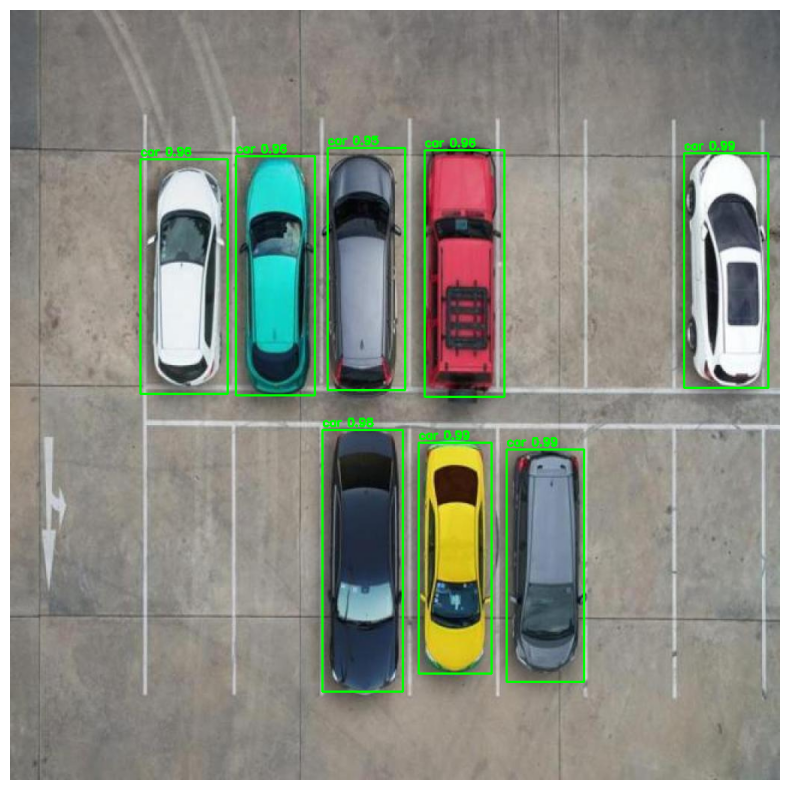

In [176]:
plt.figure(figsize=(10,10))
plt.imshow(img_np)
plt.axis("off")
plt.show()


Trying out the prediction on a video 

In [187]:
import cv2
import torch


In [188]:
model.eval()
conf_thresh = 0.5  # confidence threshold for filtering weak boxes


In [189]:
video_path = "/Users/farahalhanaya/computer-vision-project-mawqif/models_training/istockphoto-845341376-640_adpp_is.mp4"
cap = cv2.VideoCapture(video_path)

# Optional: to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_inference.mp4', fourcc, 20.0,
                      (int(cap.get(3)), int(cap.get(4))))


In [190]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame → tensor
    img = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
    img = img.unsqueeze(0)  # add batch dimension

    # Inference
    with torch.no_grad():
        preds = model(img)

    # Filter by confidence
    keep = preds[0]['scores'] >= conf_thresh
    boxes = preds[0]['boxes'][keep].cpu().numpy()
    scores = preds[0]['scores'][keep].cpu().numpy()

    # Draw detections
    for (x1, y1, x2, y2), score in zip(boxes, scores):
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, f"Car {score:.2f}", (int(x1), int(y1)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show
    cv2.imshow("Inference", frame)
    out.write(frame)  # save to video

    # Press Q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


2025-09-18 17:12:25.518 Python[3185:4284160] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
